# Gaussian Process Regression

In [1]:
from IPython.display import clear_output

import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np

import GPJax_AScannell as gpjaxas

import optax
from flax import nnx
from gpjax.parameters import DEFAULT_BIJECTION, Parameter, PositiveReal, Real, transform

# from jax.experimental import optimizers
# from gpjax.datasets import CustomDataset, NumpyLoader
# from gpjax.kernels import SquaredExponential
# from gpjax.parameters import build_constrain_params
# from gpjax.mean_functions import Zero
# from gpjax.likelihoods import Gaussian
# from gpjax.models import SVGP
# from torch.utils.data import DataLoader
from jaxtyping import Float, install_import_hook
from gpjax.parameters import Static

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax

key = jrandom.key(10)

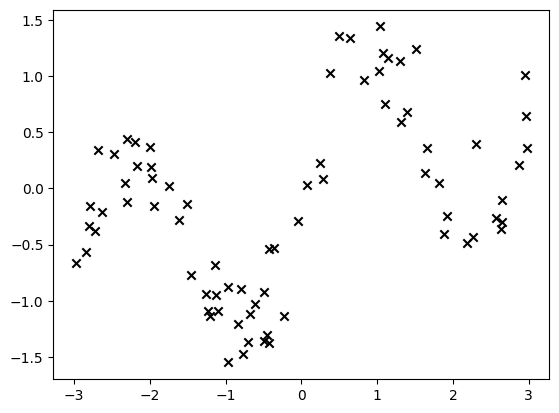

In [2]:
input_dim = 1
output_dim = 1
num_data = 75
num_test = 75
num_inducing = 50
batch_size = 60

def func(X):
    return np.sin(2*X)+ 0.3 * X + np.random.normal(0, 0.3, X.shape)

X = np.random.uniform(-3.0, 3.0, (num_data, input_dim))
Y = func(X)

plt.scatter(X[:,0], Y[:,0], marker="x", color="k")
plt.show()

In [3]:
Xtest = jnp.sort(jax.random.uniform(key, shape=(num_test, input_dim), minval=-5, maxval=5), 0)

In [4]:
train_data = gpjax.Dataset(X=X, y=Y)
kernel = gpjaxas.kernels.RBF(lengthscales=0.1, variance=0.01)
likelihood = gpjaxas.likelihoods.Gaussian(variance=1.0)
mean_function = gpjaxas.mean_functions.Zero(output_dim=output_dim)

In [5]:
gp = gpjaxas.models.GPR(kernel, likelihood, mean_function, num_latent_gps=output_dim)

In [6]:
gp_params = gp.get_params()
print(gp_params.keys())
print(gp_params)

dict_keys(['kernel', 'likelihood', 'mean_function'])
{'kernel': {'lengthscales': Array(0.1, dtype=float64, weak_type=True), 'variance': Array(0.01, dtype=float64, weak_type=True)}, 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}


In [7]:
gp_transforms = gp.get_transforms()
constrain_params = gpjaxas.parameters.build_constrain_params(gp_transforms)

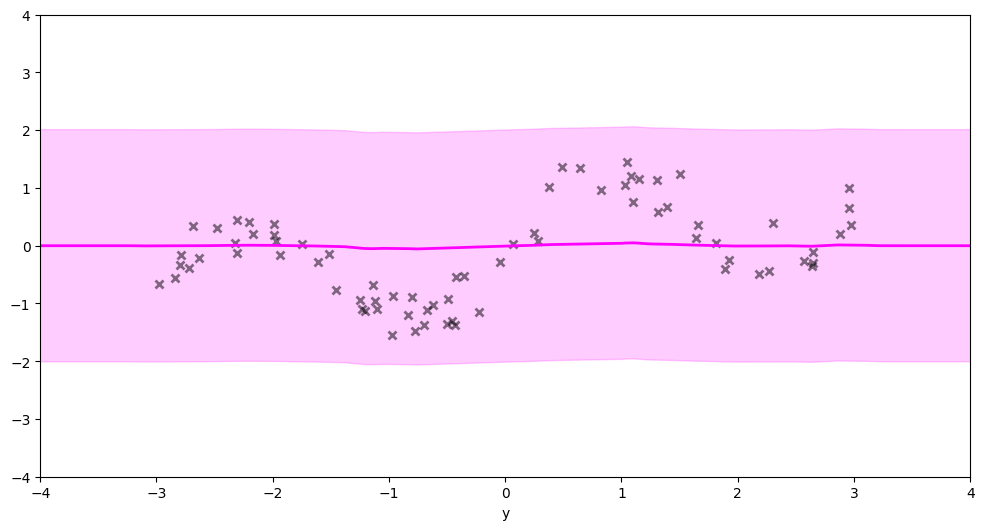

In [8]:
def plot_model(params):
    # params = constrain_params(params)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5)
    # plt.plot(params["inducing_variable"], jnp.zeros([num_inducing, input_dim]), "|", mew=2, alpha=0.5)
    mean, var = gp.predict_y(params, Xtest, train_data, full_cov=False)
    plt.plot(Xtest, mean, "magenta", lw=2)
    plt.fill_between(
        Xtest[:, 0],
        mean[:, 0] - 2 * jnp.sqrt(var[:, 0]),
        mean[:, 0] + 2 * jnp.sqrt(var[:, 0]),
        color="magenta",
        alpha=0.2,
    )
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
plot_model(gp_params)

In [9]:
print(gp_params)

{'kernel': {'lengthscales': Array(0.1, dtype=float64, weak_type=True), 'variance': Array(0.01, dtype=float64, weak_type=True)}, 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}


In [10]:
def plot_model_gpjax(posterior):
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5)
    # plt.plot(params["inducing_variable"], jnp.zeros([num_inducing, input_dim]), "|", mew=2, alpha=0.5)
    latent_dist = posterior.predict(Xtest, train_data)
    predictive_dist = posterior.likelihood(latent_dist)  # this predicts y and not f
    mean = latent_dist.mean()
    std = latent_dist.stddev()
    plt.plot(Xtest, mean, "magenta", lw=2)
    plt.fill_between(
        Xtest[:, 0],
        mean - 1.96 * std,
        mean + 1.96 * std,
        color="magenta",
        alpha=0.2,
    )
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()

In [11]:
# learning_rate = 1e-3
learning_rate = 1e-2

# Create optimizer
tx = optax.adam(learning_rate)
# gp_params = constrain_params(gp_params)
opt_state = tx.init(gp_params)

In [12]:
objective = lambda p, d: -gp.log_marginal_likelihood(p, d)

{'kernel': {'lengthscales': Array(0.1, dtype=float64, weak_type=True), 'variance': Array(0.01, dtype=float64, weak_type=True)}, 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}


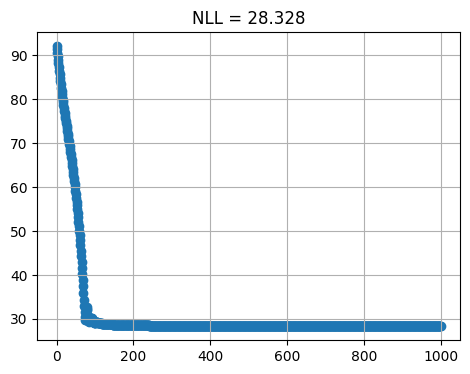

{'kernel': {'lengthscales': Array(0.1, dtype=float64, weak_type=True), 'variance': Array(0.01, dtype=float64, weak_type=True)}, 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}
{'kernel': {'lengthscales': Array(0.89424965, dtype=float64), 'variance': Array(1.10352812, dtype=float64)}, 'likelihood': {'variance': Array([0.07911348], dtype=float64)}, 'mean_function': None}


In [13]:
num_iters = 1000

# Optimisation step.
def _step_fn(carry, unused):
    params, opt_state = carry
    # params = constrain_params(params)

    loss_val, loss_gradient = jax.value_and_grad(objective)(params, train_data)
    updates, opt_state = tx.update(loss_gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    carry = params, opt_state
    return carry, loss_val

print(gp_params)

# Optimisation loop.
(optimised_params, _), loss_history = jax.lax.scan(jax.jit(_step_fn), (gp_params, opt_state), None, num_iters)

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.title("NLL = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history))
plt.grid()
plt.show()
print(gp_params)
print(optimised_params)

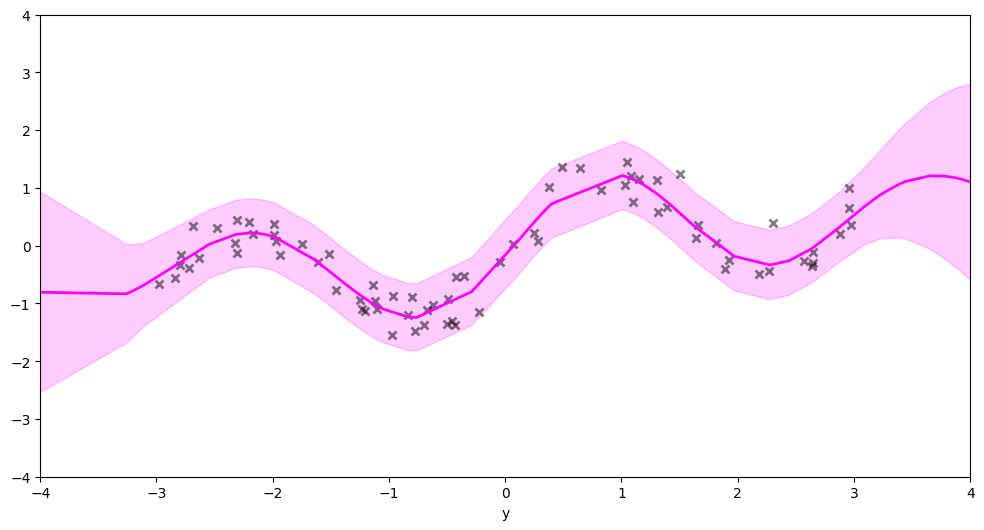

In [14]:
plot_model(optimised_params)

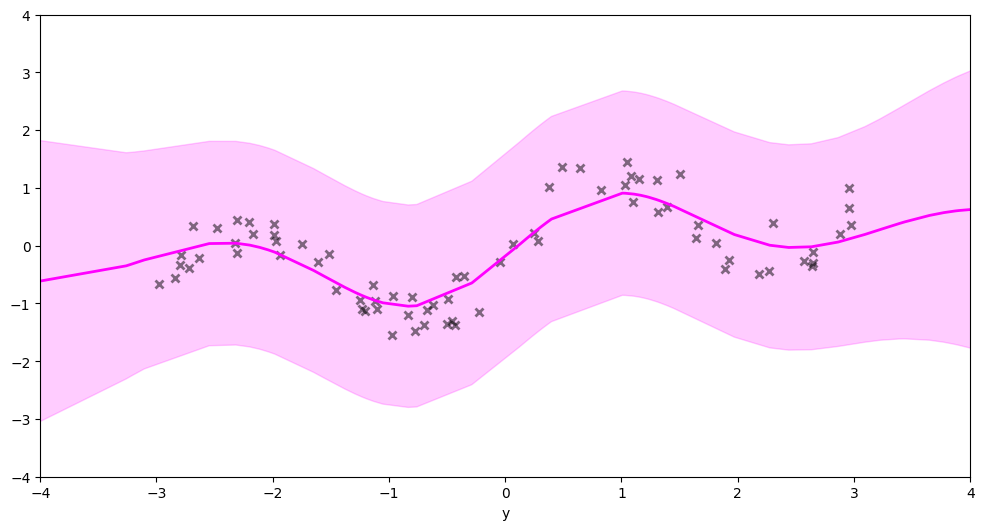

In [15]:
plot_model(constrain_params(optimised_params))

State({
  'kernel': {
    'lengthscale': VariableState(
      type=PositiveReal,
      value=Array([0.1], dtype=float64),
      _tag='positive'
    ),
    'variance': VariableState(
      type=PositiveReal,
      value=Array(0.01, dtype=float64, weak_type=True),
      _tag='positive'
    )
  },
  'mean_function': {
    'constant': VariableState(
      type=Real,
      value=Array(0., dtype=float64, weak_type=True),
      _tag='real'
    )
  }
})


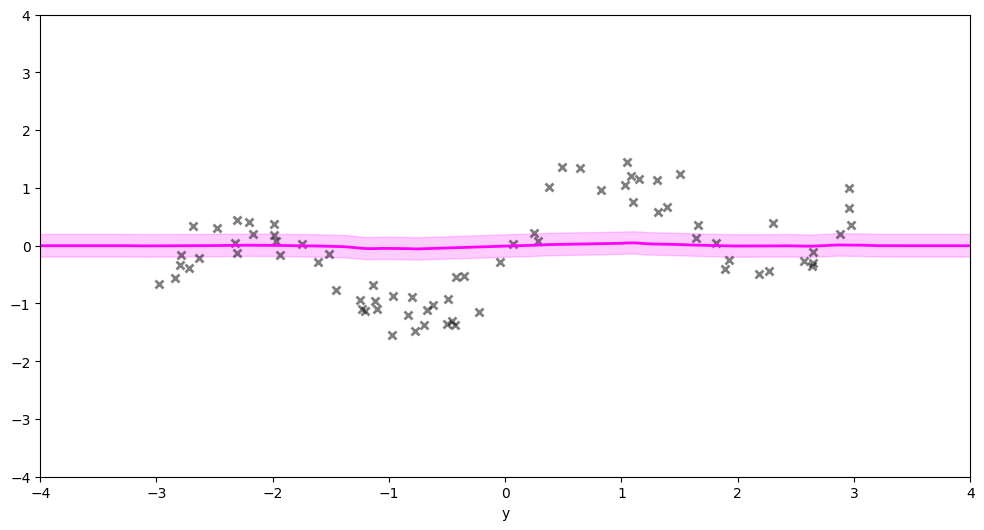

In [16]:
mean = gpjax.mean_functions.Zero()
kernel = gpjax.kernels.RBF(lengthscale=jnp.array([0.1]), variance=0.01)
prior = gpjax.gps.Prior(mean_function=mean, kernel=kernel)
likelihood = gpjax.likelihoods.Gaussian(num_datapoints=train_data.n, obs_stddev=Static(jnp.sqrt(1.0)))
posterior = prior * likelihood

_, gpjax_prior_params = nnx.split(prior, Parameter)
# _, gpjax_likelihood_params = nnx.split(likelihood, Parameter)
print(gpjax_prior_params)

plot_model_gpjax(posterior)

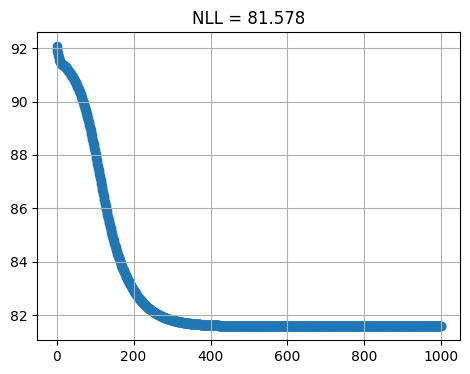

In [17]:
key, _key = jrandom.split(key)
opt_posterior, loss_history = gpjax.fit(model=posterior,
                                     objective=lambda p, d: -gpjax.objectives.conjugate_mll(p, d),
                                     train_data=train_data,
                                     optim=optax.adam(learning_rate=learning_rate),
                                     num_iters=num_iters,
                                     safe=True,
                                     key=_key,
                                     verbose=False)
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.title("NLL = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history))
plt.grid()
plt.show()

State({
  'kernel': {
    'lengthscale': VariableState(
      type=PositiveReal,
      value=Array([0.68000319], dtype=float64),
      _tag='positive'
    ),
    'variance': VariableState(
      type=PositiveReal,
      value=Array(0.43629826, dtype=float64),
      _tag='positive'
    )
  },
  'mean_function': {
    'constant': VariableState(
      type=Real,
      value=Array(-0.02811877, dtype=float64),
      _tag='real'
    )
  }
})


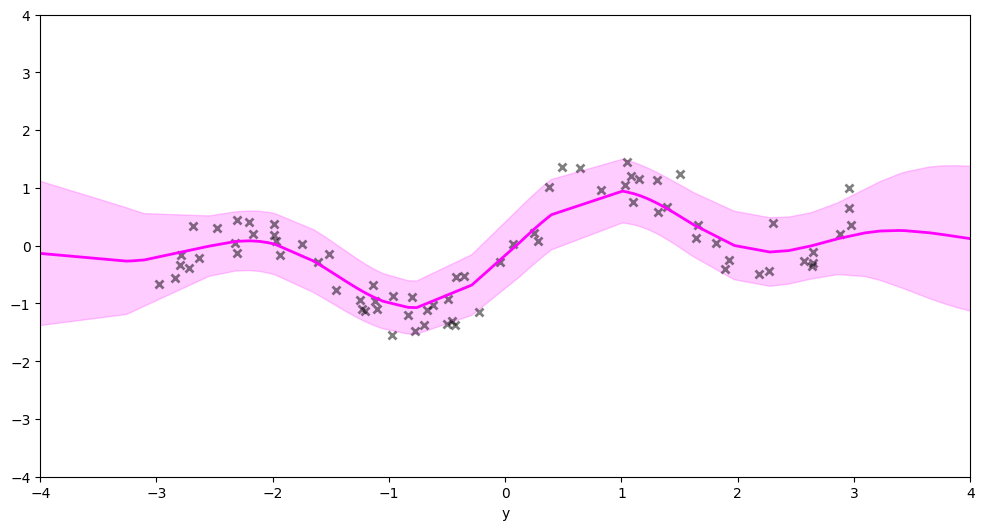

In [18]:
_, gpjax_prior_params = nnx.split(opt_posterior.prior, Parameter)
# _, gpjax_likelihood_params = nnx.split(opt_posterior.likelihood, Parameter)
print(gpjax_prior_params)

plot_model_gpjax(opt_posterior)